### 팩터 기반 주식 스크리닝
    1. 투자유니버스는 코스피 200 종목
    2. (스크리닝) 부채비율 300% 이상의 경우 제외
    2. (이익모멘텀 팩터) 12M forward EPS 변화율 zscore 계산 [2021.05.28 ~ 2021.06.28 기준]
    3. (밸류 팩터) 12M forward PER zscore 계산 (2021.06.22 기준)
    4. (저변동성 팩터) 직전 3개월 누적 수익률의 표준편차 zscore 계산 [2021.03.28 ~ 2021.06.28 기준]
    5. (퀄리티팩터) 매출총이익/자산 zscore 계산 [2020.12.31 기준]
    6. 퀄리티 20% / 저변동성 20% / 이익모멘텀 30% / 밸류 30% 비중으로 멀티팩터 스코어 합산
    7. 멀티 팩터 스코어 기준 상위 30개 종목 비중 10bp 상승
    8. 멀티 팩터 스코어 기준 하위 30개 종목 비중 10bp 하락
    따라서, 약 3%의 알파 추구

In [58]:
import pandas as pd
import FinanceDataReader as fdr
import seaborn as sns
import matplotlib as plt
from matplotlib import rc
import numpy as np
from scipy import stats
from scipy.stats.mstats import winsorize
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

In [59]:
# 코스피 200 종목 가져오기
ks200 = pd.read_csv('krx_kospi200.csv', encoding = 'euc-kr')
ks200_list = ks200['종목명'].tolist()

ks200['종목코드'] = ks200['종목코드'].map(lambda x : '0' + str(x) if len(str(x)) == 5 else x)
ks200['종목코드'] = ks200['종목코드'].map(lambda x : '00' + str(x) if len(str(x)) == 4 else x)
ks200['종목코드'] = ks200['종목코드'].map(lambda x : '000' + str(x) if len(str(x)) == 3 else x)
ks200['종목코드'] = ks200['종목코드'].map(lambda x : '0000' + str(x) if len(str(x)) == 2 else x)
ks200['종목코드'] = ks200['종목코드'].astype(str)

code_list = ks200['종목코드'].copy()
name_list = ks200['종목명'].copy()

close = pd.DataFrame()
count = 0

for code, name in zip(code_list,name_list) : 
    close[name] = fdr.DataReader(code, '2021-03')['Close']
    count =  count + 1
    print(count)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


In [60]:
standard_date = '2021-06-28'
satndard_date_t = datetime.strptime(standard_date, '%Y-%m-%d')
date_3m_before = satndard_date_t + timedelta(days=-90)

quality_standard_date = '2020-12-31'

In [61]:
### 이익모멘텀/밸류/저변동성/퀄리티 공통 종목 추출

# 이익 모멘텀 종목
earningmom = pd.read_excel('earningmom_factor.xlsx')
earningmom.columns = earningmom.iloc[8]
earningmom = earningmom.iloc[13:]
earningmom.set_index('Symbol Name', inplace = True)

# 부채비율 300% 이하 종목
quality = pd.read_csv('quality_factor.csv', encoding = 'euc_kr')
quality.columns = quality.iloc[8]
quality = quality[ks200_list]
qual_screen = pd.DataFrame()
qual_screen['name'] = quality.columns.tolist()
qual_screen['debt_ratio'] = quality.iloc[13].tolist()
qual_screen['debt_ratio'] = qual_screen['debt_ratio'].map(lambda x: np.nan if x == '완전잠식' else x)
qual_screen['debt_ratio'] = qual_screen['debt_ratio'].astype(float).dropna()
qual_screen.set_index('name', inplace = True)
qual_screen = qual_screen[qual_screen['debt_ratio'] < 300].dropna().index.tolist()

em_screen_tmp = earningmom[qual_screen].dropna(axis=1)

# 밸류 종목
per = pd.read_excel('per_12fw_factor.xlsx')
per.columns = per.iloc[8]
per = per.iloc[13:]
per.set_index('Symbol Name', inplace = True)

# 퀄리티 종목
asset = pd.read_excel('total_asset.xlsx')
asset.columns = asset.iloc[8]
asset = asset.iloc[13:]
asset.set_index('Symbol Name', inplace = True)
asset = asset.loc[quality_standard_date].astype(float).dropna()

gross_profit = pd.read_excel('gross_profit.xlsx')
gross_profit.columns = gross_profit.iloc[8]
gross_profit = gross_profit.iloc[13:]
gross_profit.set_index('Symbol Name', inplace = True)
gross_profit = gross_profit.loc[quality_standard_date].astype(float)
gross_profit = gross_profit[asset.index.tolist()]

gpa = gross_profit / asset

# 팩터별로 공통종목 적용
common_stk = per[em_screen_tmp.columns.tolist()].dropna(axis=1).columns.tolist()
common_stk = gpa[common_stk].index.tolist()
per_screen = per[common_stk]
per_screen = per_screen.loc[standard_date]
em_screen = earningmom[common_stk]
gpa_screen = gpa[common_stk]

In [62]:
# 이익모멘텀 zscore 계산

em_screen = em_screen.astype(float)
em_screen = em_screen.pct_change(30)
em_factor = pd.Series(stats.zscore(em_screen.loc[standard_date]))
em_factor_w = pd.Series(winsorize(em_factor, limits=[0.07, 0.1]))

em_df = pd.DataFrame()
em_df['name'] = em_screen.columns.tolist()
em_df['em'] = em_factor_w
em_df.set_index('name', inplace = True)

In [63]:
# 밸류 zscore 계산

per_screen = per_screen.astype(float)
val_factor = pd.Series(stats.zscore(per_screen))
val_factor_w = pd.Series(winsorize(val_factor, limits=[0, 0.03]))
val_factor_w = pd.Series(stats.zscore(val_factor_w))
val_factor_w = pd.Series(winsorize(val_factor_w, limits=[0, 0.12]))
val_factor_w = val_factor_w * -1

val_df = pd.DataFrame()
val_df['name'] = per_screen.index.tolist()
val_df['val'] = val_factor_w
val_df.set_index('name', inplace = True)

In [64]:
# 저변동성 zscore 계산
close = close[common_stk].dropna(axis=1)
std = close[date_3m_before:standard_date].pct_change().dropna().add(1).cumprod().std()
lowvol_factor = pd.Series(stats.zscore(std))
lowvol_factor_w = pd.Series(winsorize(lowvol_factor, limits=[0.1, 0.1]))
lowvol_factor_w = lowvol_factor_w * -1

lowvol_df = pd.DataFrame()
lowvol_df['name'] = close.columns.tolist()
lowvol_df['lowvol'] = lowvol_factor_w
lowvol_df.set_index('name', inplace = True)

In [65]:
# 퀄리티 zscore 계산
sns.set_style('dark')
qual_factor = pd.Series(stats.zscore(gpa_screen))
qual_factor_w = pd.Series(winsorize(qual_factor, limits=[0.2, 0.15]))

qual_df = pd.DataFrame()
qual_df['name'] = gpa_screen.index.tolist()
qual_df['qual'] = qual_factor_w
qual_df.set_index('name', inplace = True)

<AxesSubplot:>

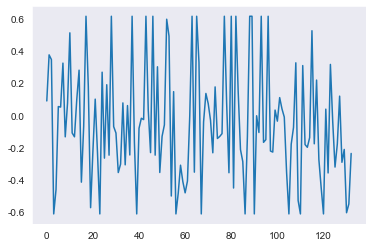

In [66]:
em_factor_w.plot()

<AxesSubplot:>

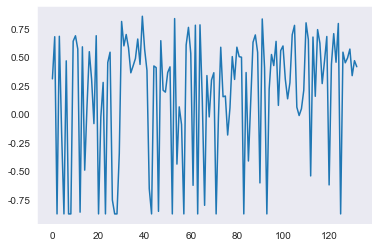

In [67]:
val_factor_w.plot()

<AxesSubplot:>

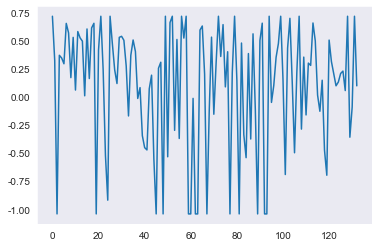

In [68]:
lowvol_factor_w.plot()

<AxesSubplot:>

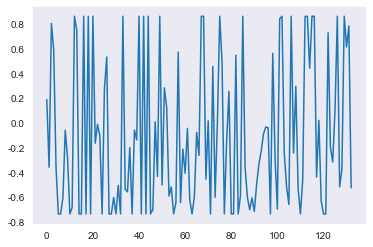

In [69]:
qual_factor_w.plot()

In [70]:
# multi factor score 산출
final_factor = pd.concat([em_df, val_df, lowvol_df, qual_df], axis=1)
final_factor['multi_factor'] = final_factor['em'] * 0.3 + final_factor['lowvol'] * 0.2 + final_factor['val'] * 0.3  +  final_factor['qual'] * 0.2   
final_factor.sort_values('multi_factor')[::-1].iloc[:10]

,em,val,lowvol,qual,multi_factor
name,,,,,
현대홈쇼핑,0.525344,0.741667,0.013734,0.861402,0.555131
DB하이텍,0.615335,0.499131,0.476410,0.546473,0.538916
LG전자,0.097587,0.590403,0.493176,0.748212,0.454674
더블유게임즈,-0.198979,0.676255,0.654544,0.861402,0.446372
SK텔레콤,-0.068940,0.547709,0.160848,0.861402,0.348081
KT,0.076737,0.581424,-0.171351,0.861402,0.335458
롯데쇼핑,0.615335,0.123796,0.627735,-0.078346,0.331617
엔씨소프트,0.180548,-0.084403,0.651881,0.861402,0.331500
한섬,-0.178099,0.543438,0.227141,0.861402,0.327311


In [71]:
final_factor.sort_values('multi_factor').iloc[:10]

,em,val,lowvol,qual,multi_factor
name,,,,,
하이브,-0.612974,-0.877759,-0.523158,-0.105072,-0.572866
포스코케미칼,-0.247875,-0.877759,0.238949,-0.736847,-0.437270
현대미포조선,0.615335,-0.877759,-1.041774,-0.736847,-0.434451
현대로템,0.148913,-0.877759,-0.336811,-0.736847,-0.433385
후성,-0.612974,-0.622896,0.502588,-0.736847,-0.417613
한화시스템,-0.612974,-0.605416,0.499406,-0.715707,-0.408777
일진머티리얼즈,-0.030263,-0.877759,0.301318,-0.736847,-0.359512
KCC,-0.451991,0.503754,-1.041774,-0.736847,-0.340195
삼성바이오로직스,0.054140,-0.877759,0.292232,-0.736847,-0.336009


In [72]:
high_10 = final_factor.sort_values('multi_factor')[::-1].iloc[:10].index.tolist()

In [73]:
low_10 = final_factor.sort_values('multi_factor').iloc[:10].index.tolist()

In [74]:
rc('font', family='Nanumgothic')
plt.rcParams['axes.unicode_minus'] = False

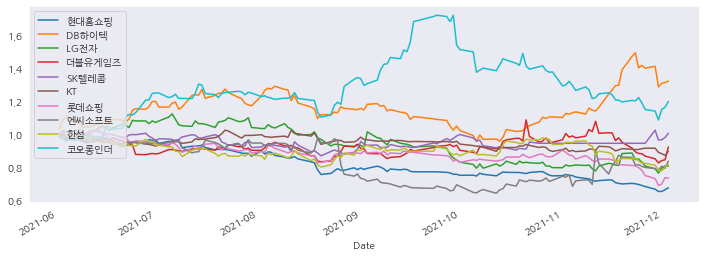

In [75]:
close[high_10].loc['2021-06-01':].pct_change().add(1).cumprod().plot(figsize = (12,4))
plt.legend(loc = 'upper left')

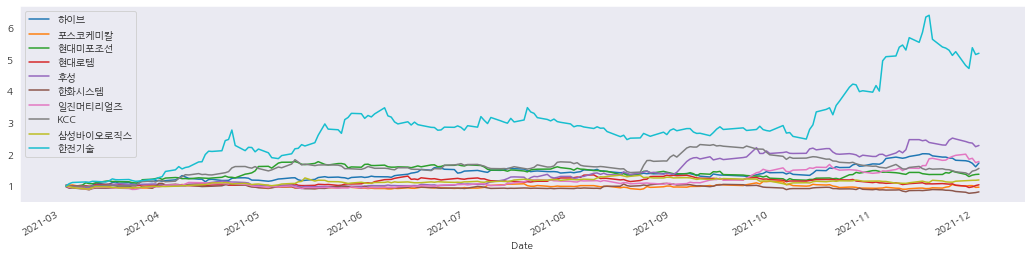

In [76]:
close[low_10].pct_change().add(1).cumprod().plot(figsize = (18,4))
plt.legend(loc = 'upper left')

In [77]:
# 현대홈쇼핑/DB하이텍/LG전자/한섬/코오롱인더 Pick

In [78]:
invest_start_date = '2021-06-30'
invest_start_date_time = datetime.strptime(invest_start_date, '%Y-%m-%d')
beta_start_date_time = invest_start_date_time + timedelta(days=-365)
beta_start_date = datetime.strftime(beta_start_date_time, '%Y-%m-%d')

In [79]:
close = pd.DataFrame()
count = 0

for code, name in zip(code_list,name_list) : 
    close[name] = fdr.DataReader(code, beta_start_date)['Close']
    count =  count + 1
    print(count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


In [80]:
stk_close = close[['현대홈쇼핑', 'DB하이텍', 'LG전자', '한섬', '코오롱인더']]
stk_ret = stk_close.pct_change().dropna()

port_ret = (stk_ret['2021-01':] / len(stk_ret.columns)).sum(axis=1)

equal_weight = 1 / len(stk_ret.columns)

In [81]:
invest_amount = 1000000
invest_amount_stk = invest_amount * equal_weight

In [82]:
quantity_1 = invest_amount_stk / stk_close.loc[invest_start_date][0]
quantity_2 = invest_amount_stk / stk_close.loc[invest_start_date][1]
quantity_3 = invest_amount_stk / stk_close.loc[invest_start_date][2]
quantity_4 = invest_amount_stk / stk_close.loc[invest_start_date][3]
quantity_5 = invest_amount_stk / stk_close.loc[invest_start_date][4]

port_n_p_q = pd.DataFrame()
port_n_p_q['종목'] = stk_close.columns.tolist()
port_n_p_q['종가'] = stk_close.loc[invest_start_date].tolist()
port_n_p_q['이론_매수수량'] = [quantity_1,quantity_2,quantity_3,
                                      quantity_4,quantity_5]
port_n_p_q['실제_매수수량'] = (port_n_p_q['이론_매수수량'].map(lambda x : round(x))).astype(int)
port_n_p_q['이론_투자금액'] = (port_n_p_q['종가'] * port_n_p_q['이론_매수수량']).astype(int)
port_n_p_q['실제_투자금액'] = (port_n_p_q['종가'] * port_n_p_q['실제_매수수량']).astype(int)
port_n_p_q['이론_비중'] = [equal_weight] * len(stk_close.columns)
port_n_p_q['실제_비중'] = port_n_p_q['실제_투자금액'] / port_n_p_q['실제_투자금액'].sum()

real_port_ret = (stk_ret['2021-01':] *  port_n_p_q['실제_비중'].tolist()).sum(axis=1)

In [83]:
ks200 = fdr.DataReader('KS200', '2021-01')['Close']
ks200_ret = ks200.pct_change().dropna()

ks200_inverse = fdr.DataReader('114800', '2021-01')['Close']
ks200_inverse_price = ks200_inverse.loc[invest_start_date]

<AxesSubplot:xlabel='Date'>

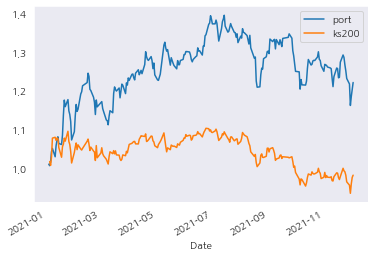

In [84]:
regress = pd.DataFrame()
regress['port'] = real_port_ret
regress['ks200'] = ks200_ret

res = ols('port ~ ks200', data=regress).fit()

regress.add(1).cumprod().plot()

In [85]:
port_beta = res.params[1]
port_beta

0.9333792408612295

In [86]:
adjusted_beta = 1/3 + 2/3 * port_beta
adjusted_beta

0.9555861605741529

In [87]:
hedge_amount = invest_amount * adjusted_beta
ks200_inverse_quantity = hedge_amount / ks200_inverse_price
ks200_inverse_quantity

259.6701523299329

In [88]:
port_n_p_q

,종목,종가,이론_매수수량,실제_매수수량,이론_투자금액,실제_투자금액,이론_비중,실제_비중
0,현대홈쇼핑,90400,2.212389,2,200000,180800,0.2,0.199152
1,DB하이텍,62400,3.205128,3,200000,187200,0.2,0.206201
2,LG전자,163500,1.223242,1,200000,163500,0.2,0.180096
3,한섬,42950,4.656577,5,200000,214750,0.2,0.236548
4,코오롱인더,80800,2.475248,2,200000,161600,0.2,0.178003


In [89]:
ks200_inverse_invest_amount = int(ks200_inverse_price * ks200_inverse_quantity)
ks200_inverse_real_invest_amount = int(ks200_inverse_price * round(ks200_inverse_quantity))

In [90]:
port_n_p_q.loc[len(port_n_p_q)] = ['코덱스인버스', ks200_inverse_price, ks200_inverse_quantity,
                                  int(round(ks200_inverse_quantity)),ks200_inverse_invest_amount,
                                   ks200_inverse_real_invest_amount, np.nan, np.nan]

In [91]:
port_n_p_q_final = port_n_p_q.iloc[:,:6]

In [92]:
port_n_p_q_final['이론_비중'] = port_n_p_q_final['이론_투자금액'] / port_n_p_q_final['이론_투자금액'].sum()

In [93]:
port_n_p_q_final['실제_비중'] = port_n_p_q_final['실제_투자금액'] / port_n_p_q_final['실제_투자금액'].sum()

In [94]:
port_n_p_q_final

,종목,종가,이론_매수수량,실제_매수수량,이론_투자금액,실제_투자금액,이론_비중,실제_비중
0,현대홈쇼핑,90400,2.212389,2,200000,180800,0.102271,0.096962
1,DB하이텍,62400,3.205128,3,200000,187200,0.102271,0.100394
2,LG전자,163500,1.223242,1,200000,163500,0.102271,0.087684
3,한섬,42950,4.656577,5,200000,214750,0.102271,0.115169
4,코오롱인더,80800,2.475248,2,200000,161600,0.102271,0.086665
5,코덱스인버스,3680,259.670152,260,955586,956800,0.488644,0.513126


In [95]:
total_invest_amount = sum(port_n_p_q_final['실제_투자금액'])

In [96]:
total_invest_amount

1864650

### 모니터링

In [97]:
# 벤치마크: kospi200
# 멀티팩터전략: buy_stk_10 - sell_stk_10
# 실제전략:buy_stk_5 - kodex200
# 추가비교전략: buy_stk_10 - kodex200

In [98]:
buy_10_ret = close[high_10].pct_change().sum(axis=1) / 10

In [99]:
sell_10_ret = close[low_10].pct_change().sum(axis=1) / 10

In [100]:
import matplotlib as mpl

print(mpl.matplotlib_fname())

C:\Users\USER\anaconda3\lib\site-packages\matplotlib\mpl-data\matplotlibrc


### 상위 10종목 주가 흐름

In [101]:
plt.rcParams["font.family"] = 'NanumGothic'

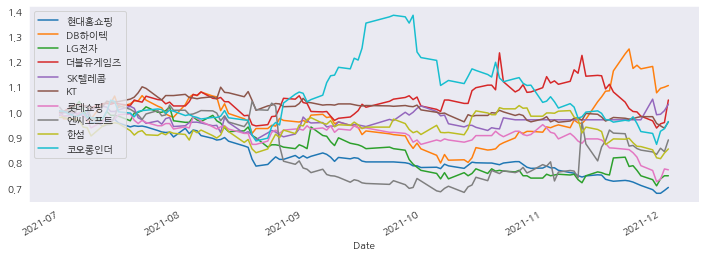

In [102]:
close[high_10]['2021-06-30':].pct_change().dropna().add(1).cumprod().plot(figsize=(12,4))
plt.legend(loc = 'upper left')

### 하위 10개 종목 주가 흐름

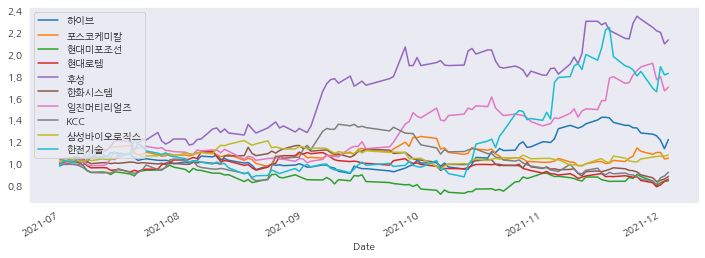

In [103]:
close[low_10]['2021-06-30':].pct_change().dropna().add(1).cumprod().plot(figsize=(12,4))
plt.legend(loc = 'upper left')

### 상위 5개 종목 주가 흐름

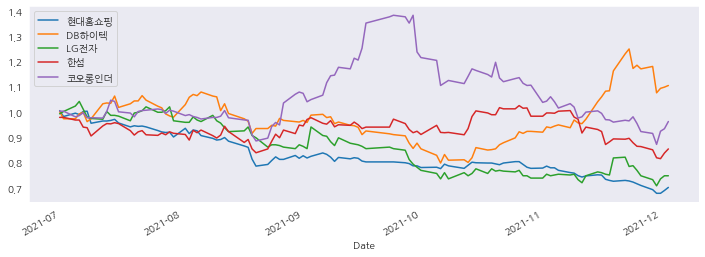

In [104]:
close[['현대홈쇼핑', 'DB하이텍', 'LG전자', '한섬', '코오롱인더']]['2021-06-30':].pct_change().dropna().add(1).cumprod().plot(figsize=(12,4))
plt.legend(loc = 'upper left')

In [105]:
monitering_df = pd.DataFrame()

In [106]:
monitering_df['벤치마크(코스피200)'] = ks200_ret['2021-07-01':]

In [107]:
monitering_df['상위10매수-하위10매도'] = (buy_10_ret - sell_10_ret)['2021-07-01':]

In [108]:
monitering_df['상위5선정-코스피200'] = (( real_port_ret ) - ( ks200_ret* adjusted_beta ))['2021-07-01':]

In [109]:
monitering_df['상위10매수-코스피200'] = (( buy_10_ret ) - ( ks200_ret* adjusted_beta ))['2021-07-01':]

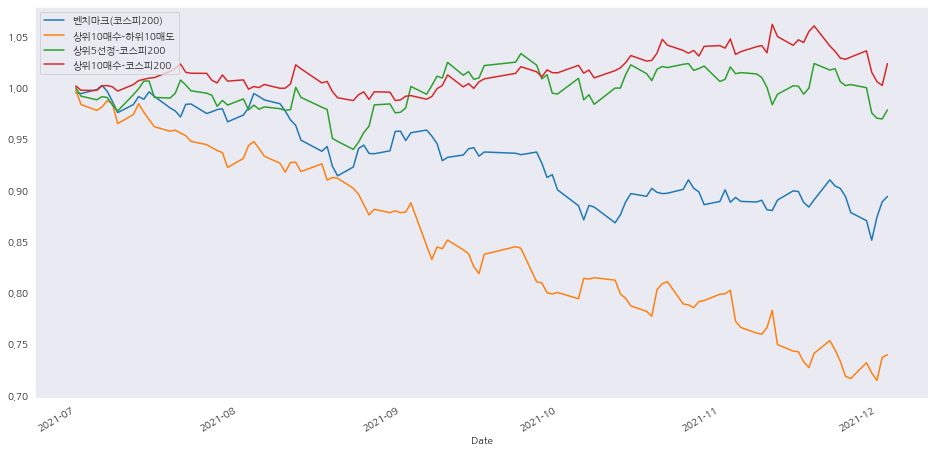

In [110]:
monitering_df.add(1).cumprod().plot(figsize=(16,8))
plt.legend(loc = 'upper left')

### 